In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
from src_dir import *
import numpy as np

dim=125
x0=np.squeeze(np.zeros((dim,1)))
x0Type='Zero Vector'

# FD_StencilMat=np.zeros((dim,dim))
# b = np.ones(dim-1)
# c = -2*np.ones(dim)
# np.fill_diagonal(FD_StencilMat[1:], b)
# np.fill_diagonal(FD_StencilMat[:,1:], b)
# np.fill_diagonal(FD_StencilMat, c)
# A=FD_StencilMat
# A=np.asmatrix(A)
A=mk_laplace_1d(dim)
AType='1D Laplacian'

retrain_freq=1
e1 = 1e-4
e2 = 1e-7
nmax_iter = 50
restart   = 64

sigma=0.02
DomainL=-5.0
DomainR=5.0
x=np.linspace(DomainL,DomainR,dim)



n_steps =2000
InputDim=dim
HiddenDim=dim
OutputDim=dim

In [4]:
# Initial log message
logger.info("Benchmark 125 dim problem. Linear gradient RHS. Test 1D linop. Benchmark on Kevin's PC. Test bug fix. Set time cutoff to 0.05. Try PRELU")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-06-12 22:42:40 [INFO] <ipython-input-4-52562db688bf> 2 - Benchmark 125 dim problem. Linear gradient RHS. Test 1D linop. Benchmark on Kevin's PC. Test bug fix. Set time cutoff to 0.05. Try PRELU


In [5]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b, x0, e, nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,refine,blist,reslist,Err_list):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [6]:
from src_dir import *



ML_GMRES_Time_list=[]

Err_list=[]
NonML_Err_List=[]

run_time_ML_list=[]
run_timeP1_ML_list=[]
run_timeP2_ML_list=[]

run_time_list=[]
GmresRunTimeOriginal=[]
GmresRunTimeOriginal2=[]

trainTime_list=[]


debug=True
refine1=False
refine2=True

blist=[]
reslist=[]



for ProbIdx in range(n_steps):

    loc=4*np.sin(0.5*ProbIdx*np.abs(np.cos(0.5*ProbIdx)))
#     b=Gauss_pdf(x,loc,sigma)
    b=(np.sin(ProbIdx)+.0001)*np.maximum(x-loc,0)
    b_norm=np.linalg.norm(b)


    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine1,blist,reslist,Err_list)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm, Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine2,blist,reslist,Err_list)
    Out2=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]

    run_timeP1_ML_list.append(run_time1_ML)
    run_timeP2_ML_list.append(run_time2_ML)
    run_time_ML_list.append(run_time1_ML+run_time2_ML)
    



    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[50])
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    
    GmresRunTimeOriginal.append(run_time1)
    GmresRunTimeOriginal2.append(run_time2)
    run_time_list.append(run_time1+run_time2)
    
    print(ProbIdx)


run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)



0
1
Final loss: 5592.41455078125
parameters 31375
Initial Training
2
size 52
0.018335526777597876 0.33671211134332835
0.4630858279997483 0.5381165005092043 0.018335526777597876 0.22228070966830826
0.4630858279997483 0.5381165005092043 0.018335526777597876 0.22228070966830826
3
size 52
0.03625112666826607 0.33671211134332835
0.5471125390031375 0.4926215180021245 0.03625112666826607 0.11424505239762968
0.5471125390031375 0.4926215180021245 0.03625112666826607 0.11424505239762968
4
size 52
0.052470593276241546 0.33671211134332835
0.421637682011351 0.5107851916691288 0.052470593276241546 0.08824707715450847
0.421637682011351 0.5107851916691288 0.052470593276241546 0.08824707715450847
5
size 52
0.02755922893183442 0.33671211134332835
0.3885649220319465 0.4772786830047456 0.02755922893183442 0.035685748907368496
0.3885649220319465 0.4772786830047456 0.02755922893183442 0.035685748907368496
6
size 52
0.05426302557559594 0.33671211134332835
0.4919454649789259 0.4551002427615458 0.0542630255755

0.33377279102569446 0.4102642512391321 0.01547223858938722 0.05325143121948299
0.33377279102569446 0.4102642512391321 0.01547223858938722 0.05325143121948299
39
size 52
0.05728879667640016 0.33671211134332835
0.41680661600548774 0.3971914399997331 0.05728879667640016 0.047735591034208665
0.41680661600548774 0.3971914399997331 0.05728879667640016 0.047735591034208665
40
size 52
0.04571382582484869 0.33671211134332835
0.444013089989312 0.3993745510000736 0.04571382582484869 0.04893593860697539
0.444013089989312 0.3993745510000736 0.04571382582484869 0.04893593860697539
41
size 52
0.01966596419704785 0.33671211134332835
0.30350684002041817 0.3951189705985598 0.01966596419704785 0.04926844819069096
0.30350684002041817 0.3951189705985598 0.01966596419704785 0.04926844819069096
42
size 52
0.04156283572678359 0.33671211134332835
0.3730758229503408 0.38553677123971286 0.04156283572678359 0.042983187734481426
0.3730758229503408 0.38553677123971286 0.04156283572678359 0.042983187734481426
43
siz

0.28241768100997433 0.30139683248475196 0.008223104400970165 0.020692085629632383
76
size 52
0.019044216160081805 0.33671211134332835
0.28564985300181434 0.30190072300611065 0.019044216160081805 0.020030993912976306
0.28564985300181434 0.30190072300611065 0.019044216160081805 0.020030993912976306
77
size 52
0.006132491755221644 0.33671211134332835
0.33706593699753284 0.3004981480049901 0.006132491755221644 0.0200617325878837
0.33706593699753284 0.3004981480049901 0.006132491755221644 0.0200617325878837
78
size 52
0.008930890041024328 0.33671211134332835
0.2822916329605505 0.30290149988606574 0.008930890041024328 0.019829920469187405
0.2822916329605505 0.30290149988606574 0.008930890041024328 0.019829920469187405
79
size 52
0.018818195269651925 0.33671211134332835
0.3734975580009632 0.299438971884083 0.018818195269651925 0.018353048649369888
0.3734975580009632 0.299438971884083 0.018818195269651925 0.018353048649369888
80
size 52
0.006660668878381664 0.33671211134332835
0.33831320499302

0.38518815697170794 0.27022551295813174 0.01233162905062458 0.011192250551125415
0.38518815697170794 0.27022551295813174 0.01233162905062458 0.011192250551125415
InnerProd [[ 1.          0.98623868 -0.90948454]
 [ 0.98623868  1.         -0.95544073]
 [-0.90948454 -0.95544073  1.        ]]
retraining
1
Final loss: 760.1694946289062
parameters 31375
114
size 52
0.0074715175110409825 0.33671211134332835
0.28294289496261626 0.2747307982761413 0.0074715175110409825 0.010872107052526534
0.28294289496261626 0.2747307982761413 0.0074715175110409825 0.010872107052526534
115
size 52
0.006314798818704536 0.33671211134332835
0.27599232003558427 0.27492629915475847 0.006314798818704536 0.01080878963553258
0.27599232003558427 0.27492629915475847 0.006314798818704536 0.01080878963553258
116
size 52
0.010104067542634494 0.33671211134332835
0.3341244490002282 0.27663429455598815 0.010104067542634494 0.010471150543565223
0.3341244490002282 0.27663429455598815 0.010104067542634494 0.010471150543565223
11

149
size 52
0.0073060996733244 0.33671211134332835
0.32711237197509035 0.25979925287654626 0.0073060996733244 0.007004305422471819
0.32711237197509035 0.25979925287654626 0.0073060996733244 0.007004305422471819
InnerProd [[ 1.         -0.9909819  -0.95272674]
 [-0.9909819   1.          0.98068527]
 [-0.95272674  0.98068527  1.        ]]
retraining
1
Final loss: 398.41162109375
parameters 31375
150
size 52
0.004871297232935886 0.33671211134332835
0.25138672604225576 0.26171813235385344 0.004871297232935886 0.00715358094235581
0.25138672604225576 0.26171813235385344 0.004871297232935886 0.00715358094235581
151
size 52
0.002705241446118226 0.33671211134332835
0.21060690196463838 0.26069400171749296 0.002705241446118226 0.006916573235408219
0.21060690196463838 0.26069400171749296 0.002705241446118226 0.006916573235408219
152
size 52
0.0032740095283821558 0.33671211134332835
0.2790992709924467 0.26325937995687126 0.0032740095283821558 0.006438444154978651
0.2790992709924467 0.26325937995687

0.1919502359814942 0.23063014696585016 0.004826740270649273 0.004320996541357872
185
size 52
0.002848571816117256 0.33671211134332835
0.27787236601579934 0.23158517100382597 0.002848571816117256 0.004405623393869828
0.27787236601579934 0.23158517100382597 0.002848571816117256 0.004405623393869828
186
size 52
0.005005955341074027 0.33671211134332835
0.27618436299962923 0.2341114241629839 0.005005955341074027 0.004435248354821752
0.27618436299962923 0.2341114241629839 0.005005955341074027 0.004435248354821752
187
size 52
0.0056133527417248944 0.33671211134332835
0.2887845759978518 0.23495669252471998 0.0056133527417248944 0.004364701924766584
0.2887845759978518 0.23495669252471998 0.0056133527417248944 0.004364701924766584
188
size 52
0.005780806081012651 0.33671211134332835
0.27811666700290516 0.23536858004517852 0.005780806081012651 0.004390348879288112
0.27811666700290516 0.23536858004517852 0.005780806081012651 0.004390348879288112
InnerProd [[ 1.          0.99352959 -0.99960277]
 [ 

220
size 52
0.0035325685892471357 0.33671211134332835
0.1811546550015919 0.2359680313570425 0.0035325685892471357 0.0033073554444060372
0.1811546550015919 0.2359680313570425 0.0035325685892471357 0.0033073554444060372
221
size 52
0.002682023916796862 0.33671211134332835
0.22296735900454223 0.23378093003761025 0.002682023916796862 0.003257281785821445
0.22296735900454223 0.23378093003761025 0.002682023916796862 0.003257281785821445
222
size 52
0.0034358012290549296 0.33671211134332835
0.18090522498823702 0.23164305939804763 0.0034358012290549296 0.0032503958769068996
0.18090522498823702 0.23164305939804763 0.0034358012290549296 0.0032503958769068996
223
size 52
0.0060296584541570195 0.33671211134332835
0.22651425399817526 0.23075679367873816 0.0060296584541570195 0.003299906169128688
0.22651425399817526 0.23075679367873816 0.0060296584541570195 0.003299906169128688
224
size 52
0.0022693514840179 0.33671211134332835
0.22381676197983325 0.23043524448061362 0.0022693514840179 0.00331616509

256
size 52
0.004150270864023875 0.33671211134332835
0.19631640997249633 0.21281307692406698 0.004150270864023875 0.0027440425413657304
0.19631640997249633 0.21281307692406698 0.004150270864023875 0.0027440425413657304
257
size 52
0.003566404991709792 0.33671211134332835
0.2281054169870913 0.209805940403603 0.003566404991709792 0.0027736142767856775
0.2281054169870913 0.209805940403603 0.003566404991709792 0.0027736142767856775
258
size 52
0.0015255583453843496 0.33671211134332835
0.16803548898315057 0.20995042144320905 0.0015255583453843496 0.0027698142331097487
0.16803548898315057 0.20995042144320905 0.0015255583453843496 0.0027698142331097487
259
size 52
0.003189473352091547 0.33671211134332835
0.19141874404158443 0.2055802187230438 0.003189473352091547 0.002733804569740687
0.19141874404158443 0.2055802187230438 0.003189473352091547 0.002733804569740687
260
size 52
0.0025324565889200154 0.33671211134332835
0.27700066997203976 0.20780264608561994 0.0025324565889200154 0.0028057340637

291
size 52
0.002771141330770275 0.33671211134332835
0.1687941619893536 0.191453780552838 0.002771141330770275 0.0022626327983146077
0.1687941619893536 0.191453780552838 0.002771141330770275 0.0022626327983146077
292
size 52
0.001034217243916401 0.33671211134332835
0.14312056999187917 0.19099693347234278 0.001034217243916401 0.0022604080607019177
0.14312056999187917 0.19099693347234278 0.001034217243916401 0.0022604080607019177
293
size 52
0.0020808892206455013 0.33671211134332835
0.19896244199480861 0.18945112863089889 0.0020808892206455013 0.0022225040500162873
0.19896244199480861 0.18945112863089889 0.0020808892206455013 0.0022225040500162873
294
size 52
0.0016303768334918628 0.33671211134332835
0.22093434602720663 0.1906835075095296 0.0016303768334918628 0.002236671070725828
0.22093434602720663 0.1906835075095296 0.0016303768334918628 0.002236671070725828
295
size 52
0.0012025814417806963 0.33671211134332835
0.12884550803573802 0.1904302344704047 0.0012025814417806963 0.00217689012

0.18086832895642146 0.13918255423894152 0.0011985653531570118 0.0018401442461038722
328
size 52
0.0027277426572802407 0.33671211134332835
0.17311095702461898 0.14124592895852403 0.0027277426572802407 0.001802812590946831
0.17311095702461898 0.14124592895852403 0.0027277426572802407 0.001802812590946831
InnerProd [[1.         0.97934297 0.99793492]
 [0.97934297 1.         0.9897421 ]
 [0.99793492 0.9897421  1.        ]]
retraining
1
Final loss: 227.652099609375
parameters 31375
329
size 52
0.0025830617577746215 0.33671211134332835
0.16795092297252268 0.1446928113186732 0.0025830617577746215 0.0018772370768616
0.16795092297252268 0.1446928113186732 0.0025830617577746215 0.0018772370768616
330
size 52
0.003205920991187125 0.33671211134332835
0.13262080895947292 0.14472813443746418 0.003205920991187125 0.0019117515079727576
0.13262080895947292 0.14472813443746418 0.003205920991187125 0.0019117515079727576
331
size 52
0.003219217352228275 0.33671211134332835
0.13296332501340657 0.1413335640

361
size 52
0.0019463956480993306 0.33671211134332835
0.14415860001463443 0.16366223571589217 0.0019463956480993306 0.0019567696999769017
0.14415860001463443 0.16366223571589217 0.0019463956480993306 0.0019567696999769017
362
size 52
0.001652789550514209 0.33671211134332835
0.1683866629609838 0.16160261935787276 0.001652789550514209 0.0019562257193555133
0.1683866629609838 0.16160261935787276 0.001652789550514209 0.0019562257193555133
363
size 52
0.0011903460055017378 0.33671211134332835
0.16699864901602268 0.16360727859660984 0.0011903460055017378 0.0019020662492888326
0.16699864901602268 0.16360727859660984 0.0011903460055017378 0.0019020662492888326
364
size 52
0.0018479720607467414 0.33671211134332835
0.1899770160089247 0.16546507323626428 0.0018479720607467414 0.0018976416898225448
0.1899770160089247 0.16546507323626428 0.0018479720607467414 0.0018976416898225448
365
size 52
0.0027754105444380167 0.33671211134332835
0.16580268100369722 0.16505985671654344 0.0027754105444380167 0.0

397
size 52
0.0032232313200015765 0.33671211134332835
0.13018684001872316 0.13379986256361007 0.0032232313200015765 0.0014559450029268583
0.13018684001872316 0.13379986256361007 0.0032232313200015765 0.0014559450029268583
398
size 52
0.0015697924289771632 0.33671211134332835
0.16865422000410035 0.13374544480349868 0.0015697924289771632 0.0015273536007751165
0.16865422000410035 0.13374544480349868 0.0015697924289771632 0.0015273536007751165
399
size 52
0.0023757677003029823 0.33671211134332835
0.16243735898751765 0.13540608804440127 0.0023757677003029823 0.0015317862410981686
0.16243735898751765 0.13540608804440127 0.0023757677003029823 0.0015317862410981686
400
size 52
0.002141089551356213 0.33671211134332835
0.17917016602586955 0.13682496196357533 0.002141089551356213 0.0015678322976665799
0.17917016602586955 0.13682496196357533 0.002141089551356213 0.0015678322976665799
InnerProd [[1.         0.94472688 0.94928105]
 [0.94472688 1.         0.99982952]
 [0.94928105 0.99982952 1.       

432
size 52
0.0011998931997274738 0.33671211134332835
0.14437804999761283 0.15028323887847364 0.0011998931997274738 0.0012226433992308043
0.14437804999761283 0.15028323887847364 0.0011998931997274738 0.0012226433992308043
433
size 52
0.0012930624081493854 0.33671211134332835
0.15187554497970268 0.15152248307829722 0.0012930624081493854 0.001239857025010039
0.15187554497970268 0.15152248307829722 0.0012930624081493854 0.001239857025010039
InnerProd [[ 1.         -0.99693524 -0.98373578]
 [-0.99693524  1.          0.99444179]
 [-0.98373578  0.99444179  1.        ]]
retraining
1
Final loss: 118.05795288085938
parameters 31375
434
size 52
0.0012247295908424482 0.33671211134332835
0.14690233499277383 0.15179665747797116 0.0012247295908424482 0.001244312398982495
0.14690233499277383 0.15179665747797116 0.0012247295908424482 0.001244312398982495
435
size 52
0.0021530929898740197 0.33671211134332835
0.14441039296798408 0.15378854919690638 0.0021530929898740197 0.001257387297581322
0.1444103929

467
size 52
0.0010370128655115473 0.33671211134332835
0.11142810399178416 0.13939586592139677 0.0010370128655115473 0.000934205995650238
0.11142810399178416 0.13939586592139677 0.0010370128655115473 0.000934205995650238
468
size 52
0.0008339717424124752 0.33671211134332835
0.09454622596967965 0.1371624746406451 0.0008339717424124752 0.0009259188090518842
0.09454622596967965 0.1371624746406451 0.0008339717424124752 0.0009259188090518842
469
size 52
0.0007541778584680438 0.33671211134332835
0.16747238696552813 0.13423915480030701 0.0007541778584680438 0.0009239652988070757
0.16747238696552813 0.13423915480030701 0.0007541778584680438 0.0009239652988070757
470
size 52
0.000959893806663748 0.33671211134332835
0.16790665197186172 0.13523816239787265 0.000959893806663748 0.0009089137032532405
0.16790665197186172 0.13523816239787265 0.000959893806663748 0.0009089137032532405
471
size 52
0.0008925336817259018 0.33671211134332835
0.1420144769945182 0.13522796507691964 0.0008925336817259018 0.00

0.11051981500349939 0.12410979450913145 0.0005418136910114159 0.0009241726847819948
503
size 52
0.0007223872586818003 0.33671211134332835
0.08697001700056717 0.12179435739060863 0.0007223872586818003 0.0008478321147217127
0.08697001700056717 0.12179435739060863 0.0007223872586818003 0.0008478321147217127
504
size 52
0.001749822114097723 0.33671211134332835
0.13148075202479959 0.12152810991043225 0.001749822114097723 0.0008491089395174359
0.13148075202479959 0.12152810991043225 0.001749822114097723 0.0008491089395174359
505
size 52
0.0008542766859240353 0.33671211134332835
0.1318263430148363 0.12100098187103868 0.0008542766859240353 0.0008827291508822755
0.1318263430148363 0.12100098187103868 0.0008542766859240353 0.0008827291508822755
506
size 52
0.000819343469247183 0.33671211134332835
0.1107028239639476 0.11953474851092323 0.000819343469247183 0.0008786785794854328
0.1107028239639476 0.11953474851092323 0.000819343469247183 0.0008786785794854328
507
size 52
0.0004944648915946107 0.33

0.09676912898430601 0.14102373143192382 0.0007693186915014563 0.000847153050053629
0.09676912898430601 0.14102373143192382 0.0007693186915014563 0.000847153050053629
538
size 52
0.0006781404826775562 0.33671211134332835
0.09604626399232075 0.13821248687338084 0.0006781404826775562 0.0008490020204916528
0.09604626399232075 0.13821248687338084 0.0006781404826775562 0.0008490020204916528
539
size 52
0.0006998344637854791 0.33671211134332835
0.11373297002865002 0.13860708359396084 0.0006998344637854791 0.0008185642024536897
0.11373297002865002 0.13860708359396084 0.0006998344637854791 0.0008185642024536897
540
size 52
0.001044972604936626 0.33671211134332835
0.143015040026512 0.13971821831539274 0.001044972604936626 0.0008264190224705001
0.143015040026512 0.13971821831539274 0.001044972604936626 0.0008264190224705001
541
size 52
0.0006483458564329484 0.33671211134332835
0.09594344499055296 0.13870375043712557 0.0006483458564329484 0.0008170517400821289
0.09594344499055296 0.138703750437125

573
size 52
0.0004468524171067815 0.33671211134332835
0.11207184399245307 0.11999246176099404 0.0004468524171067815 0.000739834974380911
0.11207184399245307 0.11999246176099404 0.0004468524171067815 0.000739834974380911
574
size 52
0.0008526347897559401 0.33671211134332835
0.0970459669479169 0.11775052611948922 0.0008526347897559401 0.0007117358088352935
0.0970459669479169 0.11775052611948922 0.0008526347897559401 0.0007117358088352935
575
size 52
0.0004971994922462738 0.33671211134332835
0.11129086703294888 0.11778374823741615 0.0004971994922462738 0.0007258030362565312
0.11129086703294888 0.11778374823741615 0.0004971994922462738 0.0007258030362565312
576
size 52
0.00031424204183594763 0.33671211134332835
0.11232418601866812 0.11556322051910684 0.00031424204183594763 0.0007137750555351429
0.11232418601866812 0.11556322051910684 0.00031424204183594763 0.0007137750555351429
577
size 52
0.0007857308122223724 0.33671211134332835
0.09751565201440826 0.11486937276087701 0.00078573081222237

0.08857329800957814 0.10739489084342495 0.00044054595629264905 0.0005859635536945495
608
size 52
0.0007922925097435656 0.33671211134332835
0.1334608179749921 0.10589094856288284 0.0007922925097435656 0.0005745645482201231
0.1334608179749921 0.10589094856288284 0.0007922925097435656 0.0005745645482201231
609
size 52
0.0006491027833633649 0.33671211134332835
0.11052288697101176 0.10675187852233649 0.0006491027833633649 0.0005921549438257653
0.11052288697101176 0.10675187852233649 0.0006491027833633649 0.0005921549438257653
610
size 52
0.0006082325608463616 0.33671211134332835
0.08817441802239046 0.10610872036078944 0.0006082325608463616 0.000591087570967459
0.08817441802239046 0.10610872036078944 0.0006082325608463616 0.000591087570967459
611
size 52
0.0006713014985785157 0.33671211134332835
0.08921227703103796 0.10622842512326315 0.0006713014985785157 0.0006010957096535722
0.08921227703103796 0.10622842512326315 0.0006713014985785157 0.0006010957096535722
612
size 52
0.00052390123050378

0.09006793797016144 0.10887511748354882 0.0006868248904404489 0.0005947838577518862
644
size 52
0.0005569931721615262 0.33671211134332835
0.134415837994311 0.107995926362928 0.0005569931721615262 0.0006014537703818723
0.134415837994311 0.107995926362928 0.0005569931721615262 0.0006014537703818723
645
size 52
0.0004981680783735795 0.33671211134332835
0.11033061001216993 0.10887679124251008 0.0004981680783735795 0.0006104913225838632
0.11033061001216993 0.10887679124251008 0.0004981680783735795 0.0006104913225838632
646
size 52
0.0006826577558915049 0.33671211134332835
0.08958274603355676 0.10978220128454268 0.0006826577558915049 0.0006091752043646269
0.08958274603355676 0.10978220128454268 0.0006826577558915049 0.0006091752043646269
647
size 52
0.0004104249916590049 0.33671211134332835
0.09002986800624058 0.10814565260661765 0.0004104249916590049 0.0006163291543455788
0.09002986800624058 0.10814565260661765 0.0004104249916590049 0.0006163291543455788
648
size 52
0.0007285874795468304 0.

679
size 52
0.0004451164756225408 0.33671211134332835
0.08696190401678905 0.11048046404495836 0.0004451164756225408 0.000506683768433538
0.08696190401678905 0.11048046404495836 0.0004451164756225408 0.000506683768433538
680
size 52
0.0004679958766757102 0.33671211134332835
0.08793693099869415 0.10953111396403983 0.0004679958766757102 0.0005042565774709729
0.08793693099869415 0.10953111396403983 0.0004679958766757102 0.0005042565774709729
681
size 52
0.0006598840089332603 0.33671211134332835
0.16699652100214735 0.10860890028532594 0.0006598840089332603 0.0005009109047462022
0.16699652100214735 0.10860890028532594 0.0006598840089332603 0.0005009109047462022
682
size 52
0.00047523121730392253 0.33671211134332835
0.1306955199688673 0.11081822024425492 0.00047523121730392253 0.000515729941546484
0.1306955199688673 0.11081822024425492 0.00047523121730392253 0.000515729941546484
683
size 52
0.00045064791186276063 0.33671211134332835
0.08745858399197459 0.11217794088181109 0.000450647911862760

0.09893390897195786 0.10884085851721466 0.0005001212944247571 0.0005516015480434088
714
size 52
0.00036618899316439083 0.33671211134332835
0.11228318104986101 0.10832962435670197 0.00036618899316439083 0.000543752682545414
0.11228318104986101 0.10832962435670197 0.00036618899316439083 0.000543752682545414
715
size 52
0.0003487286197353334 0.33671211134332835
0.11208071699365973 0.10932551519712433 0.0003487286197353334 0.0005299423268488028
0.11208071699365973 0.10932551519712433 0.0003487286197353334 0.0005299423268488028
716
size 52
0.00029491823572104357 0.33671211134332835
0.0994013849995099 0.11030738675501198 0.00029491823572104357 0.0005284603112755493
0.0994013849995099 0.11030738675501198 0.00029491823572104357 0.0005284603112755493
717
size 52
0.000731224851021167 0.33671211134332835
0.1085708099999465 0.10983466335572302 0.000731224851021167 0.0005290888742896529
0.1085708099999465 0.10983466335572302 0.000731224851021167 0.0005290888742896529
718
size 52
0.00048274923551747

749
size 52
0.0007134120604671537 0.33671211134332835
0.11131512897554785 0.10405853380449116 0.0007134120604671537 0.0005232592293835442
0.11131512897554785 0.10405853380449116 0.0007134120604671537 0.0005232592293835442
InnerProd [[ 1.         -0.94003504  0.95825366]
 [-0.94003504  1.         -0.99686738]
 [ 0.95825366 -0.99686738  1.        ]]
retraining
1
Final loss: 70.46627044677734
parameters 31375
750
size 52
0.0002495449491222446 0.33671211134332835
0.0948379029869102 0.10402033812366426 0.0002495449491222446 0.0005094369805387275
0.0948379029869102 0.10402033812366426 0.0002495449491222446 0.0005094369805387275
751
size 52
0.0003062986410082505 0.33671211134332835
0.11059168400242925 0.10335374972317368 0.0003062986410082505 0.0005054546258202055
0.11059168400242925 0.10335374972317368 0.0003062986410082505 0.0005054546258202055
752
size 52
0.00043650729098928355 0.33671211134332835
0.11093471001368016 0.10387901572277769 0.00043650729098928355 0.0005016375324436364
0.110934

0.08320715499576181 0.10635305227944628 0.0005020956630327412 0.00042186156693922906
785
size 52
0.0002320816876933714 0.33671211134332835
0.0869129030033946 0.10517585647990928 0.0002320816876933714 0.00042534121949536414
0.0869129030033946 0.10517585647990928 0.0002320816876933714 0.00042534121949536414
786
size 52
0.00045537373519913445 0.33671211134332835
0.08774400199763477 0.10293604275910184 0.00045537373519913445 0.0004202163702691708
0.08774400199763477 0.10293604275910184 0.00045537373519913445 0.0004202163702691708
787
size 52
0.0002976484325240405 0.33671211134332835
0.11089810502016917 0.10196299355942756 0.0002976484325240405 0.0004236665906001181
0.11089810502016917 0.10196299355942756 0.0002976484325240405 0.0004236665906001181
788
size 52
0.00036874387959026926 0.33671211134332835
0.08725489699281752 0.10196728436043485 0.00036874387959026926 0.0004202480854426615
0.08725489699281752 0.10196728436043485 0.00036874387959026926 0.0004202480854426615
789
size 52
0.0003115

820
size 52
0.00040038217237920153 0.33671211134332835
0.11134005000349134 0.10484367260709405 0.00040038217237920153 0.0004207830526784075
0.11134005000349134 0.10484367260709405 0.00040038217237920153 0.0004207830526784075
821
size 52
0.00038435254341160697 0.33671211134332835
0.09683564997976646 0.10489983424777165 0.00038435254341160697 0.00042519627661217986
0.09683564997976646 0.10489983424777165 0.00038435254341160697 0.00042519627661217986
822
size 52
0.0004012543554027393 0.33671211134332835
0.0928591710398905 0.1047246648464352 0.0004012543554027393 0.0004210702417189138
0.0928591710398905 0.1047246648464352 0.0004012543554027393 0.0004210702417189138
823
size 52
0.0005092883702376208 0.33671211134332835
0.16709016502136365 0.1017598873260431 0.0005092883702376208 0.00041676695820520144
0.16709016502136365 0.1017598873260431 0.0005092883702376208 0.00041676695820520144
824
size 52
0.00037989461216568276 0.33671211134332835
0.11213362700073048 0.10503988284850493 0.00037989461

855
size 52
0.000699609239015191 0.33671211134332835
0.11825151002267376 0.10514287472469733 0.000699609239015191 0.0004149203951799269
0.11825151002267376 0.10514287472469733 0.000699609239015191 0.0004149203951799269
InnerProd [[1.         0.98056458 0.93187255]
 [0.98056458 1.         0.97938486]
 [0.93187255 0.97938486 1.        ]]
retraining
1
Final loss: 57.851409912109375
parameters 31375
856
size 52
0.00033140042207640955 0.33671211134332835
0.08543078898219392 0.10542344032553956 0.00033140042207640955 0.0004252833234748667
0.08543078898219392 0.10542344032553956 0.00033140042207640955 0.0004252833234748667
857
size 52
0.00025362183211830703 0.33671211134332835
0.11287401098525152 0.10496502268593759 0.00025362183211830703 0.00043164198832186236
0.11287401098525152 0.10496502268593759 0.00025362183211830703 0.00043164198832186236
858
size 52
0.00039261898492390254 0.33671211134332835
0.08547137002460659 0.10500747272511944 0.00039261898492390254 0.00042616243348993693
0.085471

0.08798000798560679 0.10182553112972528 0.00019448806126726238 0.00038872843838976906
890
size 52
0.0002787327525853145 0.33671211134332835
0.11131457303417847 0.10087982864817605 0.0002787327525853145 0.0003767130161731947
0.11131457303417847 0.10087982864817605 0.0002787327525853145 0.0003767130161731947
891
size 52
0.0004238297146330212 0.33671211134332835
0.087879688013345 0.10087046976899729 0.0004238297146330212 0.00036780595991575086
0.087879688013345 0.10087046976899729 0.0004238297146330212 0.00036780595991575086
892
size 52
0.0003581741742939468 0.33671211134332835
0.08822096104267985 0.10069466520799324 0.0003581741742939468 0.0003725024989907098
0.08822096104267985 0.10069466520799324 0.0003581741742939468 0.0003725024989907098
893
size 52
0.00035042641559014935 0.33671211134332835
0.1107585079735145 0.09978996484773234 0.00035042641559014935 0.0003716317906368741
0.1107585079735145 0.09978996484773234 0.00035042641559014935 0.0003716317906368741
894
size 52
0.0005443334454

924
size 52
0.0005048235189240733 0.33671211134332835
0.08762439800193533 0.10000178535934538 0.0005048235189240733 0.0003678402166945241
0.08762439800193533 0.10000178535934538 0.0005048235189240733 0.0003678402166945241
925
size 52
0.0004283768119698142 0.33671211134332835
0.08589055301854387 0.10000973047921434 0.0004283768119698142 0.0003750071174093403
0.08589055301854387 0.10000973047921434 0.0004283768119698142 0.0003750071174093403
926
size 52
0.0004590831786448843 0.33671211134332835
0.1118230979773216 0.09901588344015182 0.0004590831786448843 0.00037364972465382673
0.1118230979773216 0.09901588344015182 0.0004590831786448843 0.00037364972465382673
927
size 52
0.00033182332039781925 0.33671211134332835
0.08664980594767258 0.09996527647832408 0.00033182332039781925 0.000379042200424718
0.08664980594767258 0.09996527647832408 0.00033182332039781925 0.000379042200424718
928
size 52
0.0004929074088160044 0.33671211134332835
0.08585480903275311 0.0998993100761436 0.0004929074088160

0.10835912800393999 0.10224140979582444 0.00017928903398508928 0.00036031539903419804
0.10835912800393999 0.10224140979582444 0.00017928903398508928 0.00036031539903419804
959
size 52
0.00025925985688583114 0.33671211134332835
0.1117972019710578 0.10208024447550997 0.00025925985688583114 0.00035552386663497364
0.1117972019710578 0.10208024447550997 0.00025925985688583114 0.00035552386663497364
960
size 52
0.0003793424492460927 0.33671211134332835
0.11162112199235708 0.10283306291326881 0.0003793424492460927 0.00035521010649081086
0.11162112199235708 0.10283306291326881 0.0003793424492460927 0.00035521010649081086
961
size 52
0.00018222582617158093 0.33671211134332835
0.09635932400124148 0.10377889911178499 0.00018222582617158093 0.00035622562946819285
0.09635932400124148 0.10377889911178499 0.00018222582617158093 0.00035622562946819285
962
size 52
0.0006321098783510132 0.33671211134332835
0.11053000501124188 0.10413898723199963 0.0006321098783510132 0.0003520812716344586
0.110530005011

0.11268149997340515 0.09990655788453295 0.0005286304922321388 0.0003320305088292709
0.11268149997340515 0.09990655788453295 0.0005286304922321388 0.0003320305088292709
994
size 52
0.00024655917963267796 0.33671211134332835
0.09599997202167287 0.10097641564439983 0.00024655917963267796 0.000345406015347851
0.09599997202167287 0.10097641564439983 0.00024655917963267796 0.000345406015347851
995
size 52
0.00034481018472016107 0.33671211134332835
0.09788546501658857 0.10035010024672374 0.00034481018472016107 0.0003267496809205181
0.09788546501658857 0.10035010024672374 0.00034481018472016107 0.0003267496809205181
996
size 52
0.00022759692185323442 0.33671211134332835
0.11192365002352744 0.10081021472578869 0.00022759692185323442 0.00032791202980845884
0.11192365002352744 0.10081021472578869 0.00022759692185323442 0.00032791202980845884
997
size 52
0.00030058226452595835 0.33671211134332835
0.1109703200054355 0.10185646732570604 0.00030058226452595835 0.0003237004241688409
0.1109703200054355

0.08831161697162315 0.0974087344808504 0.00039544384533344245 0.00034643343772032564
1029
size 52
0.0002815322605091498 0.33671211134332835
0.1102212070254609 0.09712723655859008 0.0002815322605091498 0.0003497705646191565
0.1102212070254609 0.09712723655859008 0.0002815322605091498 0.0003497705646191565
1030
size 52
0.00032675392402669527 0.33671211134332835
0.08885760098928586 0.09770990983815864 0.00032675392402669527 0.0003389737865352649
0.08885760098928586 0.09770990983815864 0.00032675392402669527 0.0003389737865352649
1031
size 52
0.00033873135099116354 0.33671211134332835
0.08921887702308595 0.09678989971755073 0.00033873135099116354 0.0003298495591404803
0.08921887702308595 0.09678989971755073 0.00033873135099116354 0.0003298495591404803
1032
size 52
0.00038894744215831376 0.33671211134332835
0.11097203695680946 0.09586597691755742 0.00038894744215831376 0.00032849684255659395
0.11097203695680946 0.09586597691755742 0.00038894744215831376 0.00032849684255659395
1033
size 52
0

Final loss: 8.14538860321045
parameters 31375
1063
size 52
0.0002135519521547205 0.33671211134332835
0.08663267601514235 0.100282227601856 0.0002135519521547205 0.00033859320663948996
0.08663267601514235 0.100282227601856 0.0002135519521547205 0.00033859320663948996
1064
size 52
0.0004165989181794523 0.33671211134332835
0.08693226397735998 0.10021396816242487 0.0004165989181794523 0.000338566278401617
0.08693226397735998 0.10021396816242487 0.0004165989181794523 0.000338566278401617
1065
size 52
0.00039601769785877156 0.33671211134332835
0.11199809599202126 0.09926381536060944 0.00039601769785877156 0.0003378873961667309
0.11199809599202126 0.09926381536060944 0.00039601769785877156 0.0003378873961667309
1066
size 52
0.0003571957884525574 0.33671211134332835
0.08728526800405234 0.1003365683206357 0.0003571957884525574 0.000340318118222203
0.08728526800405234 0.1003365683206357 0.0003571957884525574 0.000340318118222203
1067
size 52
0.00020875225534284486 0.33671211134332835
0.087491635

0.08958357397932559 0.10085301439277827 0.00032712977934681235 0.00032941230378550485
1098
size 52
0.0003684611760170631 0.33671211134332835
0.11079169495496899 0.09996719899121671 0.0003684611760170631 0.0003287538977438914
0.11079169495496899 0.09996719899121671 0.0003684611760170631 0.0003287538977438914
1099
size 52
0.0002773338101500905 0.33671211134332835
0.09139742498518899 0.10090872406959533 0.0002773338101500905 0.00033071702376191617
0.09139742498518899 0.10090872406959533 0.0002773338101500905 0.00033071702376191617
1100
size 52
0.00022409726847273683 0.33671211134332835
0.09002810396486893 0.1010675621102564 0.00022409726847273683 0.0003277290519793827
0.09002810396486893 0.1010675621102564 0.00022409726847273683 0.0003277290519793827
1101
size 52
0.0003365514637183189 0.33671211134332835
0.11052036203909665 0.1001922194682993 0.0003365514637183189 0.0003279998317830493
0.11052036203909665 0.1001922194682993 0.0003365514637183189 0.0003279998317830493
1102
size 52
0.000264

Final loss: 11.714057922363281
parameters 31375
1132
size 52
0.00022339277106648588 0.33671211134332835
0.09654420003062114 0.09919360660016537 0.00022339277106648588 0.00030726573606113905
0.09654420003062114 0.09919360660016537 0.00022339277106648588 0.00030726573606113905
1133
size 52
0.0002648789112583518 0.33671211134332835
0.11145228799432516 0.09948166603920981 0.0002648789112583518 0.0003080262372030825
0.11145228799432516 0.09948166603920981 0.0002648789112583518 0.0003080262372030825
1134
size 52
0.00030729417797169863 0.33671211134332835
0.11144146596780047 0.09953432907816023 0.00030729417797169863 0.00030887011221522603
0.11144146596780047 0.09953432907816023 0.00030729417797169863 0.00030887011221522603
1135
size 52
0.0001845420033550858 0.33671211134332835
0.09582555096130818 0.0996482501970604 0.0001845420033550858 0.00030879342179578956
0.09582555096130818 0.0996482501970604 0.0001845420033550858 0.00030879342179578956
1136
size 52
0.0002209518251332811 0.3367121113433

1166
size 52
0.0002844646606505067 0.33671211134332835
0.11175401997752488 0.09887344691669568 0.0002844646606505067 0.000321475712718924
0.11175401997752488 0.09887344691669568 0.0002844646606505067 0.000321475712718924
1167
size 52
0.0002976890561770291 0.33671211134332835
0.11162971297744662 0.09968830435536802 0.0002976890561770291 0.0003208992162807342
0.11162971297744662 0.09968830435536802 0.0002976890561770291 0.0003208992162807342
1168
size 52
0.0001571417646174386 0.33671211134332835
0.09585439198417589 0.10047629587585107 0.0001571417646174386 0.0003211349833174518
0.09585439198417589 0.10047629587585107 0.0001571417646174386 0.0003211349833174518
1169
size 52
0.0006290861420716126 0.33671211134332835
0.11037406895775348 0.09985301875742153 0.0006290861420716126 0.00031438102746649416
0.11037406895775348 0.09985301875742153 0.0006290861420716126 0.00031438102746649416
1170
size 52
0.00022792496292307573 0.33671211134332835
0.1113040919881314 0.10066886335611343 0.00022792496

1201
size 52
0.0001888004079045358 0.33671211134332835
0.09675044496543705 0.10109358983580023 0.0001888004079045358 0.00029740738537331596
0.09675044496543705 0.10109358983580023 0.0001888004079045358 0.00029740738537331596
1202
size 52
0.00024940801474504493 0.33671211134332835
0.09674819401698187 0.1015374448732473 0.00024940801474504493 0.00029093186805463937
0.09674819401698187 0.1015374448732473 0.00024940801474504493 0.00029093186805463937
1203
size 52
0.0002869693094932321 0.33671211134332835
0.11134634801419452 0.10099029927281662 0.0002869693094932321 0.0002899753591958232
0.11134634801419452 0.10099029927281662 0.0002869693094932321 0.0002899753591958232
1204
size 52
0.000240616848116613 0.33671211134332835
0.09554623498115689 0.10197024123277515 0.000240616848116613 0.0002861248992725486
0.09554623498115689 0.10197024123277515 0.000240616848116613 0.0002861248992725486
1205
size 52
0.00024808904980032527 0.33671211134332835
0.09616616799030453 0.10232945127179846 0.00024808

0.11421522498130798 0.09898500140290707 0.00020115217838525575 0.0002793790045779877
0.11421522498130798 0.09898500140290707 0.00020115217838525575 0.0002793790045779877
1236
size 52
0.0002558550300761283 0.33671211134332835
0.09684688597917557 0.10156349936267361 0.0002558550300761283 0.0002830915360904154
0.09684688597917557 0.10156349936267361 0.0002558550300761283 0.0002830915360904154
1237
size 52
0.0003446604558847288 0.33671211134332835
0.0970872929901816 0.10159763076342643 0.0003446604558847288 0.00028314886997698937
0.0970872929901816 0.10159763076342643 0.0003446604558847288 0.00028314886997698937
1238
size 52
0.0002725841568363279 0.33671211134332835
0.11774458200670779 0.1010370166040957 0.0002725841568363279 0.0002861267877347122
0.11774458200670779 0.1010370166040957 0.0002725841568363279 0.0002861267877347122
1239
size 52
0.0002723993424142201 0.33671211134332835
0.09930355404503644 0.10119653584435583 0.0002723993424142201 0.00028631893342707324
0.09930355404503644 0.1

0.09741019801003858 0.10030953587964177 0.0003409715155511012 0.00029489732184958915
0.09741019801003858 0.10030953587964177 0.0003409715155511012 0.00029489732184958915
1271
size 52
0.0001984602709427767 0.33671211134332835
0.08774389798054472 0.10056789295980707 0.0001984602709427767 0.00029556913714905435
0.08774389798054472 0.10056789295980707 0.0001984602709427767 0.00029556913714905435
1272
size 52
0.00028211698105680183 0.33671211134332835
0.08770315698347986 0.09960562595864758 0.00028211698105680183 0.0002918830856719683
0.08770315698347986 0.09960562595864758 0.00028211698105680183 0.0002918830856719683
1273
size 52
0.0002844080148930958 0.33671211134332835
0.11075906903715804 0.09867115875706077 0.0002844080148930958 0.0002887882573936478
0.11075906903715804 0.09867115875706077 0.0002844080148930958 0.0002887882573936478
1274
size 52
0.0003079300577144195 0.33671211134332835
0.08734396402724087 0.09923721335828305 0.0003079300577144195 0.0002870053363492387
0.087343964027240

0.11098332598339766 0.1033375882380642 0.00023488505390047398 0.0002861711937649522
0.11098332598339766 0.1033375882380642 0.00023488505390047398 0.0002861711937649522
1306
size 52
0.0002462528661270561 0.33671211134332835
0.0963658049586229 0.10332029091659933 0.0002462528661270561 0.00027972905016387906
0.0963658049586229 0.10332029091659933 0.0002462528661270561 0.00027972905016387906
1307
size 52
0.00013328939080735206 0.33671211134332835
0.10771571402437985 0.10341726603452116 0.00013328939080735206 0.00026643349012552497
0.10771571402437985 0.10341726603452116 0.00013328939080735206 0.00026643349012552497
1308
size 52
0.00022858117378267223 0.33671211134332835
0.11611007095780224 0.10325575251597911 0.00022858117378267223 0.00026649287896093904
0.11611007095780224 0.10325575251597911 0.00022858117378267223 0.00026649287896093904
1309
size 52
0.00027364721589102296 0.33671211134332835
0.09817226702580228 0.10343003871385008 0.00027364721589102296 0.0002603981422645486
0.0981722670

1340
size 52
0.0004321799888902931 0.33671211134332835
0.11106899497099221 0.10266903531970456 0.0004321799888902931 0.00023600381268053575
0.11106899497099221 0.10266903531970456 0.0004321799888902931 0.00023600381268053575
InnerProd [[ 1.         -0.96632672  0.95078451]
 [-0.96632672  1.         -0.99757334]
 [ 0.95078451 -0.99757334  1.        ]]
retraining
1
Final loss: 14.290918350219727
parameters 31375
1341
size 52
0.0003838706459773548 0.33671211134332835
0.11098126298747957 0.10266421959968283 0.0003838706459773548 0.00024627236089194064
0.11098126298747957 0.10266421959968283 0.0003838706459773548 0.00024627236089194064
1342
size 52
0.0002736385760212597 0.33671211134332835
0.11097397602861747 0.10326208675978706 0.0002736385760212597 0.00025185660128516246
0.11097397602861747 0.10326208675978706 0.0002736385760212597 0.00025185660128516246
1343
size 52
0.0002494222360125817 0.33671211134332835
0.09557862399378791 0.103259963481687 0.0002494222360125817 0.0002529204047078691

0.11234331800369546 0.09696974212303758 0.00022368999644532312 0.0002753153134645776
0.11234331800369546 0.09696974212303758 0.00022368999644532312 0.0002753153134645776
1374
size 52
0.00030100767867567534 0.33671211134332835
0.0847851749858819 0.09703630248317495 0.00030100767867567534 0.00027377571100383065
0.0847851749858819 0.09703630248317495 0.00030100767867567534 0.00027377571100383065
1375
size 52
0.0003175037760932302 0.33671211134332835
0.08668772398959845 0.09678873160388321 0.0003175037760932302 0.00027663533718735303
0.08668772398959845 0.09678873160388321 0.0003175037760932302 0.00027663533718735303
1376
size 52
0.00022316079682004302 0.33671211134332835
0.08717098098713905 0.09583509972319007 0.00022316079682004302 0.0002727830505538354
0.08717098098713905 0.09583509972319007 0.00022316079682004302 0.0002727830505538354
1377
size 52
0.00020362323427910116 0.33671211134332835
0.11133013502694666 0.0948784980433993 0.00020362323427910116 0.00027022490740476727
0.1113301350

0.11125211702892557 0.10378440724220127 0.0002822190688314373 0.0002924957378600819
0.11125211702892557 0.10378440724220127 0.0002822190688314373 0.0002924957378600819
1409
size 52
0.00034776140398632896 0.33671211134332835
0.08960971399210393 0.10473674528300762 0.00034776140398632896 0.00029061737615468456
0.08960971399210393 0.10473674528300762 0.00034776140398632896 0.00029061737615468456
1410
size 52
0.00022773422059715174 0.33671211134332835
0.09262192598544061 0.10385158736258746 0.00022773422059715174 0.0002959194571659609
0.09262192598544061 0.10385158736258746 0.00022773422059715174 0.0002959194571659609
1411
size 52
0.0003412998232011277 0.33671211134332835
0.09193421801319346 0.10411243984010071 0.0003412998232011277 0.00029598672792206267
0.09193421801319346 0.10411243984010071 0.0003412998232011277 0.00029598672792206267
1412
size 52
0.00026038785341489274 0.33671211134332835
0.11158807302126661 0.10428971060086041 0.00026038785341489274 0.0002982513250542322
0.1115880730

Final loss: 19.23655128479004
parameters 31375
1444
size 52
0.00025915212238934883 0.33671211134332835
0.09337418101495132 0.09645705115515739 0.00025915212238934883 0.00029149204186828094
0.09337418101495132 0.09645705115515739 0.00025915212238934883 0.00029149204186828094
1445
size 52
0.000260112324889642 0.33671211134332835
0.09457130898954347 0.09574835695559158 0.000260112324889642 0.0002837665692828863
0.09457130898954347 0.09574835695559158 0.000260112324889642 0.0002837665692828863
1446
size 52
0.00040489728244154914 0.33671211134332835
0.11088144301902503 0.0950657252338715 0.00040489728244154914 0.0002848208598180935
0.11088144301902503 0.0950657252338715 0.00040489728244154914 0.0002848208598180935
1447
size 52
0.0003740802325942812 0.33671211134332835
0.09122931899037212 0.09582582651637495 0.0003740802325942812 0.0002867542863729437
0.09122931899037212 0.09582582651637495 0.0003740802325942812 0.0002867542863729437
1448
size 52
0.00031824220154122776 0.33671211134332835
0.

1479
size 52
0.00024913233228675144 0.33671211134332835
0.11206631100503728 0.09920120044611394 0.00024913233228675144 0.0002581210835761363
0.11206631100503728 0.09920120044611394 0.00024913233228675144 0.0002581210835761363
1480
size 52
0.00031922730082861034 0.33671211134332835
0.09194355504587293 0.1002414592448622 0.00031922730082861034 0.00025924487034486725
0.09194355504587293 0.1002414592448622 0.00031922730082861034 0.00025924487034486725
1481
size 52
0.00019098546981444808 0.33671211134332835
0.09181004203855991 0.09943420828552917 0.00019098546981444808 0.00026259837961662466
0.09181004203855991 0.09943420828552917 0.00019098546981444808 0.00026259837961662466
1482
size 52
0.00013750153866113463 0.33671211134332835
0.056641144037712365 0.09971957348752766 0.00013750153866113463 0.0002571200272639764
0.056641144037712365 0.09971957348752766 0.00013750153866113463 0.0002571200272639764
1483
size 52
0.00023888529795227054 0.33671211134332835
0.11200843803817406 0.09851821888936

1514
size 52
0.00026415908634531217 0.33671211134332835
0.11100287700537592 0.09538420535856858 0.00026415908634531217 0.0002551742979178932
0.11100287700537592 0.09538420535856858 0.00026415908634531217 0.0002551742979178932
InnerProd [[ 1.         -0.96688619  0.99889789]
 [-0.96688619  1.         -0.97616235]
 [ 0.99889789 -0.97616235  1.        ]]
retraining
1
Final loss: 20.284549713134766
parameters 31375
1515
size 52
0.0002859488131458248 0.33671211134332835
0.0853531519533135 0.09607659787870944 0.0002859488131458248 0.00024480299395882667
0.0853531519533135 0.09607659787870944 0.0002859488131458248 0.00024480299395882667
1516
size 52
0.000461218488172817 0.33671211134332835
0.0851648100069724 0.09564393899869174 0.000461218488172817 0.00024301378090686262
0.0851648100069724 0.09564393899869174 0.000461218488172817 0.00024301378090686262
1517
size 52
0.00023016171369689633 0.33671211134332835
0.11375552497338504 0.09678045063978061 0.00023016171369689633 0.00025596284785910366


1548
size 52
0.00022187387385907677 0.33671211134332835
0.11356295394944027 0.10191703775897622 0.00022187387385907677 0.00026406261298475065
0.11356295394944027 0.10191703775897622 0.00022187387385907677 0.00026406261298475065
1549
size 52
0.00028591425250720467 0.33671211134332835
0.09601877199020237 0.10297581855673343 0.00028591425250720467 0.00026141465930809316
0.09601877199020237 0.10297581855673343 0.00028591425250720467 0.00026141465930809316
1550
size 52
0.00021960876175760392 0.33671211134332835
0.11411926802247763 0.10227075755596161 0.00021960876175760392 0.00026186302011256226
0.11411926802247763 0.10227075755596161 0.00021960876175760392 0.00026186302011256226
1551
size 52
0.0002573850885388432 0.33671211134332835
0.12011857103789225 0.10340643203584478 0.0002573850885388432 0.0002626917717745227
0.12011857103789225 0.10340643203584478 0.0002573850885388432 0.0002626917717745227
1552
size 52
0.00024513197391906 0.33671211134332835
0.09558509796625003 0.10472593039739878 

0.11163874296471477 0.09780807971721515 0.00018981618293256852 0.0002490323217055774
1584
size 52
0.000253017070533237 0.33671211134332835
0.09151614794973284 0.09850575803546235 0.000253017070533237 0.00024787731474824415
0.09151614794973284 0.09850575803546235 0.000253017070533237 0.00024787731474824415
1585
size 52
0.000314787969612899 0.33671211134332835
0.0913960809702985 0.09828662587329745 0.000314787969612899 0.0002522167156875284
0.0913960809702985 0.09828662587329745 0.000314787969612899 0.0002522167156875284
1586
size 52
0.00017211904797662193 0.33671211134332835
0.11134185502305627 0.09745364659233019 0.00017211904797662193 0.000254631606136675
0.11134185502305627 0.09745364659233019 0.00017211904797662193 0.000254631606136675
1587
size 52
0.00030487509821959367 0.33671211134332835
0.11108728597173467 0.09747419627383351 0.00030487509821959367 0.00025264630736251216
0.11108728597173467 0.09747419627383351 0.00030487509821959367 0.00025264630736251216
1588
size 52
0.00019965

1618
size 52
0.00016043076815475826 0.33671211134332835
0.09208314499119297 0.09983835875755176 0.00016043076815475826 0.00027267149696880627
0.09208314499119297 0.09983835875755176 0.00016043076815475826 0.00027267149696880627
1619
size 52
0.00025004700520787513 0.33671211134332835
0.10711631900630891 0.09907730259932578 0.00025004700520787513 0.0002734001858622314
0.10711631900630891 0.09907730259932578 0.00025004700520787513 0.0002734001858622314
1620
size 52
0.00026445692256181177 0.33671211134332835
0.11189966800156981 0.09887576643843204 0.00026445692256181177 0.00027353721431598604
0.11189966800156981 0.09887576643843204 0.00026445692256181177 0.00027353721431598604
1621
size 52
0.0002712247448232967 0.33671211134332835
0.09068121598102152 0.09954378183931112 0.0002712247448232967 0.0002755688175532254
0.09068121598102152 0.09954378183931112 0.0002712247448232967 0.0002755688175532254
1622
size 52
0.00016257689437408632 0.33671211134332835
0.09740468999370933 0.09898710571695118

1653
size 52
0.00026240438847802345 0.33671211134332835
0.11063295404892415 0.09550829580053687 0.00026240438847802345 0.00022795053587633843
0.11063295404892415 0.09550829580053687 0.00026240438847802345 0.00022795053587633843
1654
size 52
0.00028690716057463414 0.33671211134332835
0.11010370799340308 0.09643538716249168 0.00028690716057463414 0.00022888085974226188
0.11010370799340308 0.09643538716249168 0.00028690716057463414 0.00022888085974226188
InnerProd [[ 1.         -0.99293508 -0.99973855]
 [-0.99293508  1.          0.99526932]
 [-0.99973855  0.99526932  1.        ]]
retraining
1
Final loss: 19.353858947753906
parameters 31375
1655
size 52
0.0002826265521137244 0.33671211134332835
0.08595419902121648 0.09736940624192357 0.0002826265521137244 0.00023027516148273433
0.08595419902121648 0.09736940624192357 0.0002826265521137244 0.00023027516148273433
1656
size 52
0.0002549459589840868 0.33671211134332835
0.11251188098685816 0.09634158096276224 0.0002549459589840868 0.00023397946

1687
size 52
0.00023020849529071057 0.33671211134332835
0.08416949899401516 0.09816161315888167 0.00023020849529071057 0.00021992849989299761
0.08416949899401516 0.09816161315888167 0.00023020849529071057 0.00021992849989299761
1688
size 52
0.00027111594199680494 0.33671211134332835
0.08586210000794381 0.09778652255889028 0.00027111594199680494 0.0002215476272507553
0.08586210000794381 0.09778652255889028 0.00027111594199680494 0.0002215476272507553
1689
size 52
0.0001755601677904942 0.33671211134332835
0.08625773398671299 0.09676626923726872 0.0001755601677904942 0.00021712441402570222
0.08625773398671299 0.09676626923726872 0.0001755601677904942 0.00021712441402570222
1690
size 52
0.00025905795840630835 0.33671211134332835
0.11085189500590786 0.0963755292375572 0.00025905795840630835 0.00021699266797125735
0.11085189500590786 0.0963755292375572 0.00025905795840630835 0.00021699266797125735
1691
size 52
0.00021766999421320295 0.33671211134332835
0.08645347302081063 0.09710529587930068

0.0859434749581851 0.0953659801138565 0.00027558952617766044 0.00023575124373978487
1722
size 52
0.00015346276382262276 0.33671211134332835
0.08688439603429288 0.09428006655303761 0.00015346276382262276 0.0002305598508612019
0.08688439603429288 0.09428006655303761 0.00015346276382262276 0.0002305598508612019
1723
size 52
0.000249683659320086 0.33671211134332835
0.08764492796035483 0.09432513579493389 0.000249683659320086 0.00022497296767745904
0.08764492796035483 0.09432513579493389 0.000249683659320086 0.00022497296767745904
1724
size 52
0.00024676794698023815 0.33671211134332835
0.11226132902083918 0.09439001531340181 0.00024676794698023815 0.00022685810554887807
0.11226132902083918 0.09439001531340181 0.00024676794698023815 0.00022685810554887807
1725
size 52
0.00019478978229144802 0.33671211134332835
0.08682968694483861 0.09440839015413076 0.00019478978229144802 0.00022283783202955567
0.08682968694483861 0.09440839015413076 0.00019478978229144802 0.00022283783202955567
1726
size 52

0.097715898999013 0.09790081111714244 0.00028914227300556124 0.0002278789240297759
1756
size 52
0.0002626436740867274 0.33671211134332835
0.11319357197498903 0.09830529311671853 0.0002626436740867274 0.00022757919908575865
0.11319357197498903 0.09830529311671853 0.0002626436740867274 0.00022757919908575865
1757
size 52
0.00031531676844937054 0.33671211134332835
0.11328787897946313 0.09831062307581305 0.00031531676844937054 0.00022477148046673635
0.11328787897946313 0.09831062307581305 0.00031531676844937054 0.00022477148046673635
1758
size 52
0.00031469724226915034 0.33671211134332835
0.09812455798964947 0.09831460835644976 0.00031469724226915034 0.0002270719764354057
0.09812455798964947 0.09831460835644976 0.00031469724226915034 0.0002270719764354057
1759
size 52
0.00019423012583020996 0.33671211134332835
0.11726847704267129 0.098754879955668 0.00019423012583020996 0.0002304798312609624
0.11726847704267129 0.098754879955668 0.00019423012583020996 0.0002304798312609624
1760
size 52
0.0

0.09716433304129168 0.10109227455221116 0.000295897517993577 0.00023064610644296757
1791
size 52
0.00021496478528998205 0.33671211134332835
0.11311277700588107 0.10048599711386487 0.00021496478528998205 0.00023675781599076745
0.11311277700588107 0.10048599711386487 0.00021496478528998205 0.00023675781599076745
1792
size 52
0.00014495231012955689 0.33671211134332835
0.10584616201231256 0.10117151647340507 0.00014495231012955689 0.00023558282512335264
0.10584616201231256 0.10117151647340507 0.00014495231012955689 0.00023558282512335264
1793
size 52
0.000283988969964525 0.33671211134332835
0.09683337196474895 0.10092584767378866 0.000283988969964525 0.0002281843854005372
0.09683337196474895 0.10092584767378866 0.000283988969964525 0.0002281843854005372
1794
size 52
0.0003048543306322006 0.33671211134332835
0.11286561901215464 0.10036318459315226 0.0003048543306322006 0.00023247291175509786
0.11286561901215464 0.10036318459315226 0.0003048543306322006 0.00023247291175509786
InnerProd [[ 1.

0.11244631599402055 0.09614389524329453 0.00026365202949484706 0.00022314597401885332
0.11244631599402055 0.09614389524329453 0.00026365202949484706 0.00022314597401885332
InnerProd [[ 1.         -0.99551425 -0.98873297]
 [-0.99551425  1.          0.9983607 ]
 [-0.98873297  0.9983607   1.        ]]
retraining
1
Final loss: 0.5199294090270996
parameters 31375
1827
size 52
0.00015763252569258785 0.33671211134332835
0.09416752401739359 0.09725195108447224 0.00015763252569258785 0.00022513895731840857
0.09416752401739359 0.09725195108447224 0.00015763252569258785 0.00022513895731840857
1828
size 52
0.00023111962038826843 0.33671211134332835
0.1111647579818964 0.097569696046412 0.00023111962038826843 0.000222994427154666
0.1111647579818964 0.097569696046412 0.00023111962038826843 0.000222994427154666
1829
size 52
0.0001973321325976616 0.33671211134332835
0.11062026600120589 0.09858185808407142 0.0001973321325976616 0.00022086090456567453
0.11062026600120589 0.09858185808407142 0.00019733213

0.1104524849797599 0.09686301256064325 0.0001682858858921241 0.00021081135223799532
0.1104524849797599 0.09686301256064325 0.0001682858858921241 0.00021081135223799532
1861
size 52
0.000152411949324744 0.33671211134332835
0.11057765496661887 0.09685661172028631 0.000152411949324744 0.00021061903957907504
0.11057765496661887 0.09685661172028631 0.000152411949324744 0.00021061903957907504
1862
size 52
0.0002776747884089616 0.33671211134332835
0.08968845999334008 0.09755921992007643 0.0002776747884089616 0.00020851729853817123
0.08968845999334008 0.09755921992007643 0.0002776747884089616 0.00020851729853817123
1863
size 52
0.0001935965988705454 0.33671211134332835
0.08969667699420825 0.09744062168058008 0.0001935965988705454 0.0002126259227124433
0.08969667699420825 0.09744062168058008 0.0001935965988705454 0.0002126259227124433
1864
size 52
0.00015290857424598873 0.33671211134332835
0.11117066396400332 0.0965342410793528 0.00015290857424598873 0.00020954829240506993
0.11117066396400332 0

1895
size 52
0.00027591948644711795 0.33671211134332835
0.09255784301785752 0.09516005363781005 0.00027591948644711795 0.00021550271573789816
0.09255784301785752 0.09516005363781005 0.00027591948644711795 0.00021550271573789816
1896
size 52
0.0002636715151326947 0.33671211134332835
0.11932379298377782 0.09538432352012023 0.0002636715151326947 0.00021843164992762883
0.11932379298377782 0.09538432352012023 0.0002636715151326947 0.00021843164992762883
1897
size 52
0.0002534089054929347 0.33671211134332835
0.11115985497599468 0.0956801898800768 0.0002534089054929347 0.00022028648553989807
0.11115985497599468 0.0956801898800768 0.0002534089054929347 0.00022028648553989807
InnerProd [[ 1.         -0.98367755  0.97898016]
 [-0.98367755  1.         -0.99965276]
 [ 0.97898016 -0.99965276  1.        ]]
retraining
1
Final loss: 2.5543737411499023
parameters 31375
1898
size 52
0.000162056839640836 0.33671211134332835
0.09796789800748229 0.09651110496139154 0.000162056839640836 0.000217050935752213

1928
size 52
0.00014966451873297222 0.33671211134332835
0.08888645598199219 0.09705077071906999 0.00014966451873297222 0.0002003542227101007
0.08888645598199219 0.09705077071906999 0.00014966451873297222 0.0002003542227101007
1929
size 52
0.00014922382694467068 0.33671211134332835
0.0889310140046291 0.09863469123840332 0.00014922382694467068 0.00020227505856221066
0.0889310140046291 0.09863469123840332 0.00014922382694467068 0.00020227505856221066
1930
size 52
0.00025891167600740746 0.33671211134332835
0.08942062401911244 0.09826552559854462 0.00025891167600740746 0.0001981766696459927
0.08942062401911244 0.09826552559854462 0.00025891167600740746 0.0001981766696459927
1931
size 52
0.00013848312630317504 0.33671211134332835
0.11105497303651646 0.09740464611910284 0.00013848312630317504 0.00019522012929791018
0.11105497303651646 0.09740464611910284 0.00013848312630317504 0.00019522012929791018
1932
size 52
0.00021407505880373972 0.33671211134332835
0.08887204702477902 0.0973715164419263

1962
size 52
0.00025863854886463544 0.33671211134332835
0.1111675730207935 0.09881794885033741 0.00025863854886463544 0.0002095029637538769
0.1111675730207935 0.09881794885033741 0.00025863854886463544 0.0002095029637538769
1963
size 52
0.0002802421475595621 0.33671211134332835
0.11153740697773173 0.09873999465024098 0.0002802421475595621 0.00021275213832448633
0.11153740697773173 0.09873999465024098 0.0002802421475595621 0.00021275213832448633
1964
size 52
0.0002299943876423311 0.33671211134332835
0.09290957800112665 0.09874194640899077 0.0002299943876423311 0.0002159596012160115
0.09290957800112665 0.09874194640899077 0.0002299943876423311 0.0002159596012160115
1965
size 52
0.00014736203429065363 0.33671211134332835
0.11186254897620529 0.09874022172996774 0.00014736203429065363 0.00021335497791058383
0.11186254897620529 0.09874022172996774 0.00014736203429065363 0.00021335497791058383
1966
size 52
0.00015394738258287628 0.33671211134332835
0.11132566101150587 0.09877945828717202 0.00

0.11178589996416122 0.09677777875214816 0.00018766027684630703 0.00019887652550410894
1997
size 52
0.0002022993865490584 0.33671211134332835
0.08759967901278287 0.09936556067084894 0.0002022993865490584 0.00020148948435950832
0.08759967901278287 0.09936556067084894 0.0002022993865490584 0.00020148948435950832
1998
size 52
0.00020213266552261477 0.33671211134332835
0.0868685360183008 0.09840179571183398 0.00020213266552261477 0.00020422667991838657
0.0868685360183008 0.09840179571183398 0.00020213266552261477 0.00020422667991838657


2020-06-12 23:54:51 [INFO] <ipython-input-6-601cd50eec3f> 78 - Runtime of Non-decorated version is:
2020-06-12 23:54:51 [INFO] <ipython-input-6-601cd50eec3f> 79 - 2208.4762055832543
2020-06-12 23:54:51 [INFO] <ipython-input-6-601cd50eec3f> 81 - Runtime of MLGMRES decorator is:
2020-06-12 23:54:51 [INFO] <ipython-input-6-601cd50eec3f> 82 - 1611.84850377182
2020-06-12 23:54:51 [INFO] <ipython-input-6-601cd50eec3f> 85 - Runtime of training (backprop) is:
2020-06-12 23:54:51 [INFO] <ipython-input-6-601cd50eec3f> 86 - 275.46992533566663


1999


In [7]:
import matplotlib.pyplot as pp
from src_dir import *

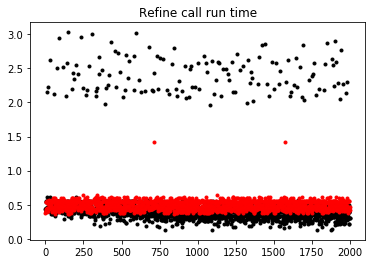

In [8]:
pp.plot(run_timeP2_ML_list,'.k',GmresRunTimeOriginal2,'.r')
pp.title('Refine call run time')
pp.savefig('Test_2.png')

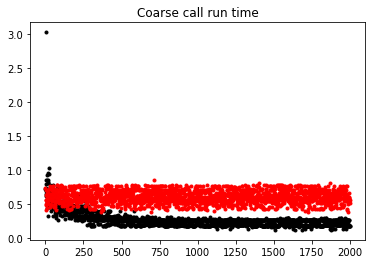

In [9]:
pp.plot(run_timeP1_ML_list,'.k',GmresRunTimeOriginal,'.r')
pp.title('Coarse call run time')
pp.savefig('Test_1.png')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:65: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


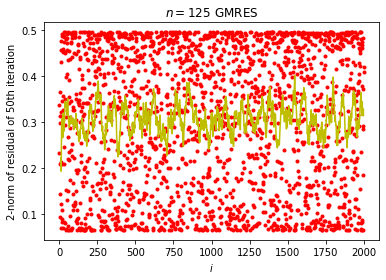

In [10]:
AVG=np.zeros((n_steps,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)

for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[10:-1],AVG[10:-1],'y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('$n=125$ GMRES')
pp.savefig('GMRES.png')

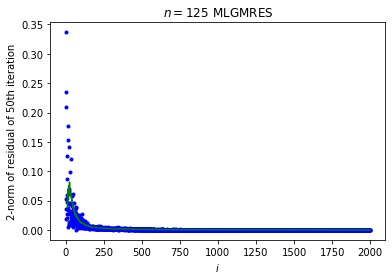

In [11]:
Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))

for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)

pp.plot(count,np.asarray(Err_Array_ML),'.b',count[10:-1],AVGML[10:-1],'g')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('$n=125$ MLGMRES')
pp.savefig('MLGMRES.png')

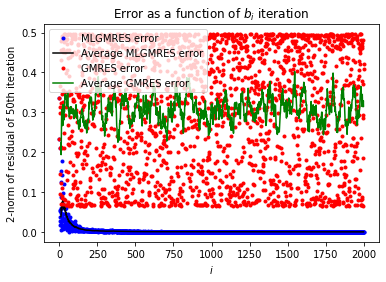

In [12]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('Error as a function of $b_i$ iteration ')
pp.legend(loc='best')
pp.savefig('Compare.png')

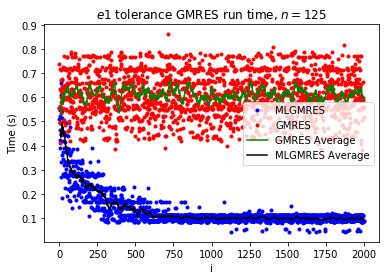

In [13]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')




pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n=125$')
pp.legend(loc='best')
pp.savefig('Runtime.png')

#### 